In [126]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
# speech-silence and voice-unvoiced
BASE_TRAIN_PATH = "TinHieuHuanLuyen"
BASE_TEST_PATH = "TinHieuKiemThu"

def read_lab(lab_file_name: str):
    """Read lab file
    lab_file_name: str, name of lab file
    Return: list of lists [start_time, end_time, label]
    """
    data = []
    with open(lab_file_name) as f:
        for line in f.readlines():
            data.append(line.split())
    return data



In [127]:


def load_data(audio_name: str, base_path):
    """
    Load audio and lab file, create time vector with length equal to audio length
    """
    signal, sr = librosa.load(os.path.join(base_path, f"{audio_name}.wav"))
    lab_data = read_lab(os.path.join(base_path, f"{audio_name}.lab"))
    timestamp_label = lab_data[:-2]
    t_i = 0
    t_f = signal.shape[0] / sr
    t = np.linspace(t_i, t_f, num=signal.shape[0])
    return signal, sr, t, timestamp_label



In [128]:
class SpeechSlienceDiscriminatorHistogram:
    """
    Class to predict speech-silence 
    """
    def __init__(self, audio_name_list, signal_list, sr_list, t_list, timestamp_label_list):
        self.audio_name_list = audio_name_list
        self.signal_list = signal_list
        self.sr_list = sr_list
        self.t_list = t_list
        self.timestamp_label_list = timestamp_label_list
        # calculate log_ste
        self.calc_STE_norm()
        self.calc_log_STE_norm()
        self.calc_silent_frame_idx()
        
    def calc_STE_norm(self, frame_length = 0.02):
        """
        Calculate STE with normalization
        """
        self.STE_norm_list = []
        self.frame_edges_list = []
        for signal, sr, in zip(self.signal_list, self.sr_list):
            STE = []
            frame_size = int(sr * frame_length)
            frames_count = len(signal) // frame_size
            frame_edges = []
            for i in range(frames_count):
                startIdx = i * frame_size
                stop_Idx = startIdx + frame_size
                window = np.zeros(signal.shape)
                window[startIdx:stop_Idx] = 1
                value = np.sum(np.square(signal) * window)
                STE.append(value)
                frame_edges.append(startIdx)
            STE = np.array(STE)
            STE = STE.reshape(-1)
            self.STE = STE
            frame_edges = np.array(frame_edges)
            frame_edges = frame_edges.reshape(-1)
            STE_norm = (STE - np.min(STE)) / (np.max(STE) - np.min(STE))
            STE_norm[STE_norm == 0] = 1e-10
            self.STE_norm_list.append(STE_norm) 
            self.frame_edges_list.append(frame_edges) 
    
    def calc_log_STE_norm(self):
        """
        Calculate log STE norm
        """
        self.log_STE_norm_list = []
        for STE in self.STE_norm_list:
            self.log_STE_norm_list.append(np.log(STE))

    def calc_silent_frame_idx(self):
        """
        Create an array of 0 and 1, 1 if frame is in silence, 0 otherwise
        """
        self.silent_frame_idx_list = []
        self.frame_in_silence_list = []
        
        for timestamp_label, frame_edges, t, STE_norm in zip(self.timestamp_label_list, self.frame_edges_list, self.t_list, self.STE_norm_list):
            silent_timestamps = list(filter(lambda x: x[2] == "sil", timestamp_label))
            silent_timestamps = list(map(lambda x: x[:2], silent_timestamps))
            silent_idx = []
            for timestamp_pair in silent_timestamps:
                start = float(timestamp_pair[0])
                end = float(timestamp_pair[1])
                start_idx = len(t[t < start])
                end_idx = len(t[t < end])
                silent_idx.append((start_idx, end_idx))
            silent_frame_idx = []
            for idx_pair in silent_idx:
                frame_size = frame_edges[1] - frame_edges[0]
                start_idx = int(idx_pair[0] / frame_size)
                end_idx = int(idx_pair[1] / frame_size)
                silent_frame_idx.append((start_idx, end_idx))
            self.silent_frame_idx_list.append( silent_frame_idx)
            frame_in_silence = np.full(STE_norm.shape, 0)
            for idx_pair in silent_frame_idx:
                frame_in_silence[idx_pair[0] : idx_pair[1] + 1] = 1
            self.frame_in_silence_list.append(frame_in_silence)
        



    def HistogramMethod(self):
        plt.hist(self.STE, bins=100)
        log_STE_norm_in_silence = []
        log_STE_norm_in_speech = []
        for i in range(len(self.signal_list)):
            log_STE_norm_in_silence.append(self.log_STE_norm_list[i][self.frame_in_silence_list[i] == 1])
            log_STE_norm_in_speech.append(self.log_STE_norm_list[i][self.frame_in_silence_list[i] == 0])
        log_STE_norm_in_silence = np.concatenate(log_STE_norm_in_silence, axis=0)
        log_STE_norm_in_speech = np.concatenate(log_STE_norm_in_speech, axis=0)
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 10))
        bin_width = 0.1
        bin_num_silence = int((np.max(log_STE_norm_in_silence) - np.min(log_STE_norm_in_silence)) / bin_width)
        bin_num_speech = int(np.max(log_STE_norm_in_speech) - np.min(log_STE_norm_in_speech) / bin_width)
        bin_vals_silence, edges_silence, n_silence = axs.hist(log_STE_norm_in_silence, alpha = 0.5, label = 'Log STE in silence frame', bins=bin_num_silence)
        bin_vals_speech, edges_speech, n_speech = axs.hist(log_STE_norm_in_speech, alpha = 0.5, label='Log STE in speech frame', bins=bin_num_speech)
        overlapping_part =np.min(edges_speech), np.max(edges_silence)
        thresholds = np.arange(overlapping_part[0], overlapping_part[1], 0.01)
        speech_overlapping_list = []
        silence_overlapping_list = []
        total_overlapping_list = []
        fig.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
        
        print("Threshold sẽ nằm trong khoảng min(ste_speech) và max(ste_silence))")
        print("Cách tính các điểm nhầm lẫn: khoảng nhầm lẫn sẽ tính từ threshold, những điểm speech nằm bên trái threshold sẽ là nhầm lẫn thuộc speech\n\
Những điểm silence nằm bên phải threshold sẽ là nhầm lẫn thuộc silence")
        
        for threshold in thresholds:
            speech_overlapping = np.sum(bin_vals_speech[edges_speech[:-1] < threshold])
            silence_overlapping = np.sum(bin_vals_silence[edges_silence[:-1] > threshold])
            total_overlapping = speech_overlapping + silence_overlapping
            speech_overlapping_list.append(speech_overlapping)
            silence_overlapping_list.append(silence_overlapping)
            total_overlapping_list.append(total_overlapping)
        plt.plot( thresholds, speech_overlapping_list)
        plt.plot( thresholds, silence_overlapping_list)
        plt.plot(thresholds, total_overlapping_list)
        plt.xlabel('Threshold')
        plt.legend(['speech overlapping', 'silence overlapping', 'total overlapping'])
        
        plt.show()
        
        print("Từ đồ thị ta thấy được tại điểm giao nhau giữa 2 đường cong số các điểm nhầm lẫn giữa speech và silence\nthì tổng số điểm dữ liệu nhầm lẫn sẽ là nhỏ nhất hoặc tiệm cận nhỏ nhất\n")
        print("Từ đó sử dụng phương pháp nội suy, ta tìm được điểm giao nhau giữa 2 đường cong, điểm đó là ngưỡng tốt nhất để phân biệt speech và silence")
        
        spline1 = InterpolatedUnivariateSpline(thresholds, speech_overlapping_list)
        spline2 = InterpolatedUnivariateSpline(thresholds, silence_overlapping_list)
        
        threshold = thresholds[np.argmin(np.abs(spline1(thresholds) - spline2(thresholds)))]
        print(f"Threshold found: {threshold}")

        return threshold, log_STE_norm_in_silence, log_STE_norm_in_speech

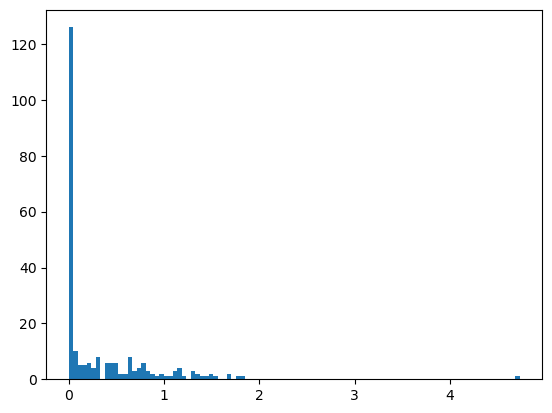

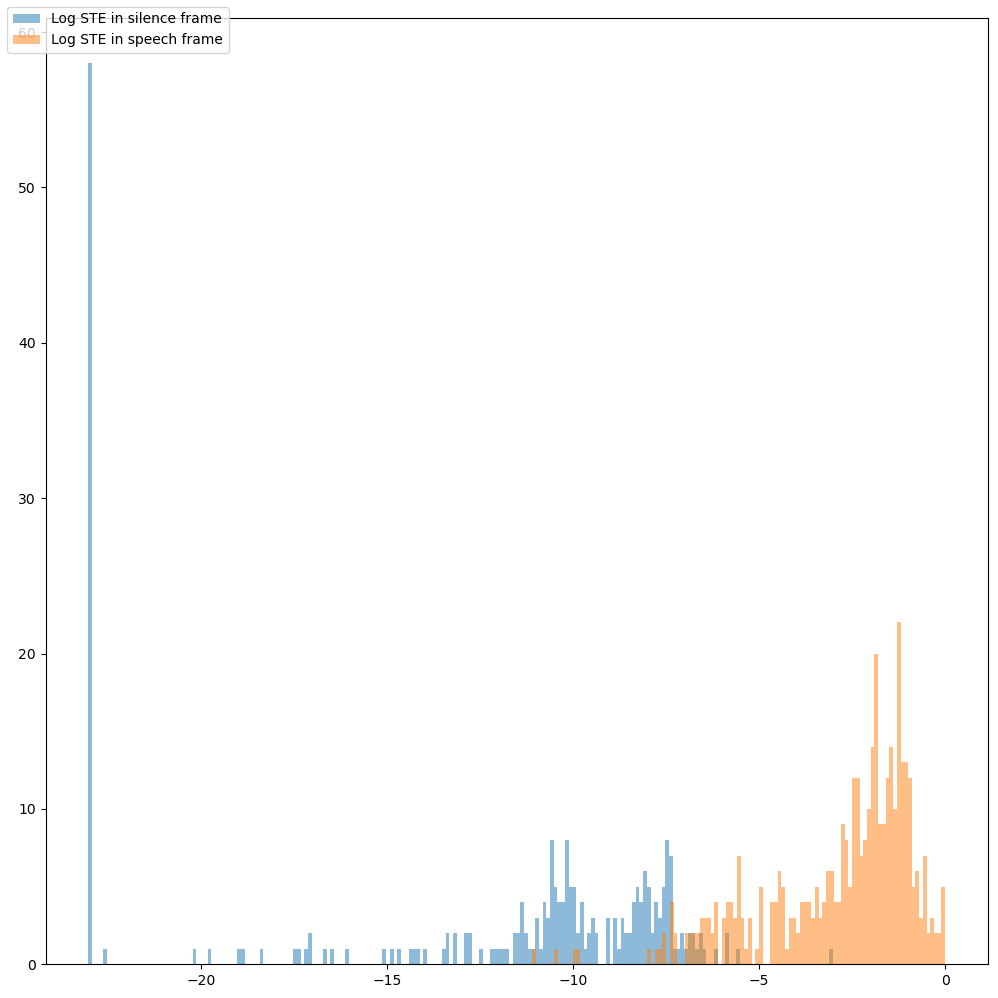

Threshold sẽ nằm trong khoảng min(ste_speech) và max(ste_silence))
Cách tính các điểm nhầm lẫn: khoảng nhầm lẫn sẽ tính từ threshold, những điểm speech nằm bên trái threshold sẽ là nhầm lẫn thuộc speech
Những điểm silence nằm bên phải threshold sẽ là nhầm lẫn thuộc silence


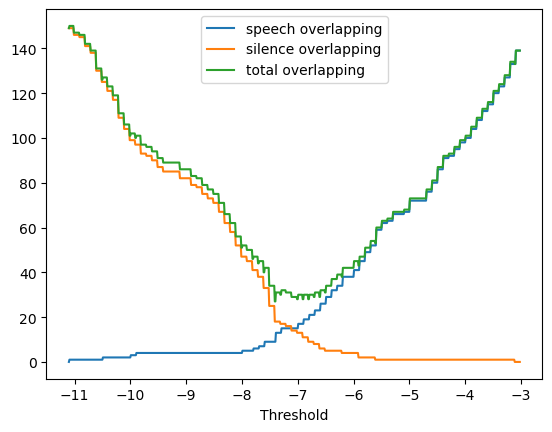

Từ đồ thị ta thấy được tại điểm giao nhau giữa 2 đường cong số các điểm nhầm lẫn giữa speech và silence
thì tổng số điểm dữ liệu nhầm lẫn sẽ là nhỏ nhất hoặc tiệm cận nhỏ nhất

Từ đó sử dụng phương pháp nội suy, ta tìm được điểm giao nhau giữa 2 đường cong, điểm đó là ngưỡng tốt nhất để phân biệt speech và silence
Threshold found: -7.16235273723372


NameError: name 'TEST_PATH' is not defined

In [129]:
audio_name_train_list = list(
    filter(lambda x: x.endswith(".wav"), os.listdir(BASE_TRAIN_PATH))
)
audio_name_train_list = list(map(lambda x: x[:-4], audio_name_train_list))
signal_list = [0] * len(audio_name_train_list)
sr_list = [0] * len(audio_name_train_list)
t_list = [0] * len(audio_name_train_list)
timestamp_label_list = [0] * len(audio_name_train_list)
signal_frames_list = [0] * len(audio_name_train_list)
frame_size_list = [0] * len(audio_name_train_list)
frames_count_list = [0] * len(audio_name_train_list)

for i in range(len(audio_name_train_list)):
    signal_list[i], sr_list[i], t_list[i], timestamp_label_list[i] = load_data(
        audio_name_train_list[i],
        BASE_TRAIN_PATH
    )

b = SpeechSlienceDiscriminatorHistogram(
    audio_name_list=audio_name_train_list,
    signal_list=signal_list,
    sr_list=sr_list,
    t_list=t_list,
    timestamp_label_list=timestamp_label_list,
)

threshold, log_STE_norm_in_silence, log_STE_norm_in_speech = b.HistogramMethod()

audio_name_test_list = list(
    filter(lambda x: x.endwith(".wav"), os.listdir(TEST_PATH))
)
